In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt 

In [2]:
mydata = pd.read_csv('20051201_20051210.csv',index_col='Date')

In [3]:
mydata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-12-01,10806.030273,10934.900391,10806.030273,10912.570313,10912.570313,256980000
2005-12-02,10912.009766,10921.370117,10861.660156,10877.509766,10877.509766,214900000
2005-12-05,10876.950195,10876.950195,10810.669922,10835.009766,10835.009766,237340000
2005-12-06,10835.410156,10936.200195,10835.410156,10856.860352,10856.860352,264630000
2005-12-07,10856.860352,10868.059570,10764.009766,10810.910156,10810.910156,243490000
2005-12-08,10808.429688,10847.250000,10729.669922,10755.120117,10755.120117,253290000
2005-12-09,10751.759766,10805.950195,10729.910156,10778.580078,10778.580078,238930000


In [4]:
def add_original_feature(df, df_new):
    df_new['open']      = df['Open']
    df_new['open_1']    = df['Open'].shift(1)
    df_new['close_1']   = df['Close'].shift(1)
    df_new['high_1']    = df['High'].shift(1)
    df_new['low_1']     = df['Low'].shift(1)
    df_new['volume_1']  = df['Volume'].shift(1)

In [5]:
def add_avg_price(df, df_new):
    df_new['avg_price_5']              = df['Close'].rolling(5).mean().shift(1) #week excluding weekends
    df_new['avg_price_30']             = df['Close'].rolling(21).mean().shift(1) #month excluding weekends
    df_new['avg_price_365']            = df['Close'].rolling(252).mean().shift(1) #year excluding weekends
    df_new['ratio_avg_price_5_30']     = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365']    = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365']   = df_new['avg_price_30'] / df_new['avg_price_365']


In [6]:
def add_avg_volume(df, df_new):
    df_new['avg_volume_5']             = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30']            = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365']           = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30']    = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365']   = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365']  = df_new['avg_volume_30'] / df_new['avg_volume_365']

In [7]:
def add_std_price(df, df_new):
    df_new['std_price_5']               = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30']              = df['Close'].rolling(21).std().shift(1) 
    df_new['std_price_365']             = df['Close'].rolling(252).std().shift(1) 
    
    df_new['ratio_std_price_5_30']      = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365']     = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365']    = df_new['std_price_30'] / df_new['std_price_365']

In [8]:
def add_std_volume(df, df_new):
     df_new['std_volume_5']             = df['Volume'].rolling(5).std().shift(1)
     df_new['std_volume_30']            = df['Volume'].rolling(21).std().shift(1)
     df_new['std_volume_365']           = df['Volume'].rolling(252).std().shift(1)
     
     df_new['ratio_std_volume_5_30']    = df_new['std_volume_5'] / df_new['std_volume_30']
     df_new['ratio_std_volume_5_365']   = df_new['std_volume_5'] / df_new['std_volume_365']
     df_new['ratio_std_volume_30_365']  = df_new['std_volume_30'] / df_new['std_volume_365']

In [9]:
def add_return_feature(df, df_new):
     df_new['return_1']         = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
     df_new['return_5']         = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
     df_new['return_30']        = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
     df_new['return_365']       = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
     
     df_new['moving_avg_5']     = df_new['return_1'].rolling(5).mean().shift(1)
     df_new['moving_avg_30']    = df_new['return_1'].rolling(21).mean().shift(1)
     df_new['moving_avg_365']   = df_new['return_1'].rolling(252).mean().shift(1)

In [10]:
def generate_features(df):
     """
     Generate features for a stock/index based on historical price and performance
     @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
     @return: dataframe, data set with new features
     """
     df_new = pd.DataFrame()
     # 6 original features
     add_original_feature(df, df_new)
     # 31 generated features
     add_avg_price(df, df_new)
     add_avg_volume(df, df_new)
     add_std_price(df, df_new)
     add_std_volume(df, df_new)
     add_return_feature(df, df_new)
     # the target
     df_new['close'] = df['Close']
     df_new = df_new.dropna(axis=0)
     return df_new

In [11]:
data_raw = pd.read_csv('19880101_20161231.csv',index_col='Date')

In [12]:
data = generate_features(data_raw)

In [13]:
data.round(decimals=3).tail(5)

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_365,ratio_avg_price_5_30,...,ratio_std_volume_5_365,ratio_std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,19908.609,19922.680,19918.881,19933.830,19882.189,258290000.0,19912.386,19535.447,17881.613,1.019,...,1.977,2.040,-0.001,0.003,0.047,0.132,0.002,0.002,0.001,19933.811
2016-12-27,19943.461,19908.609,19933.811,19934.150,19899.061,158260000.0,19930.466,19575.953,17891.064,1.018,...,0.819,1.981,0.001,0.005,0.045,0.136,0.001,0.002,0.001,19945.039
2016-12-28,19964.311,19943.461,19945.039,19980.240,19939.801,158540000.0,19942.862,19613.710,17900.654,1.017,...,0.884,1.878,0.001,0.003,0.041,0.138,0.001,0.002,0.001,19833.680
2016-12-29,19835.461,19964.311,19833.680,19981.109,19827.311,188350000.0,19914.674,19648.748,17909.038,1.014,...,0.739,1.798,-0.006,-0.007,0.039,0.119,0.001,0.002,0.001,19819.779
2016-12-30,19833.170,19835.461,19819.779,19878.439,19788.939,172040000.0,19890.238,19681.994,17917.831,1.011,...,0.612,1.715,-0.001,-0.006,0.037,0.126,-0.001,0.002,0.000,19762.600


In [14]:
date_split = '2016'
train_data = data.loc[data.index < date_split]
test_data = data.loc[data.index > date_split]
X_train = train_data.drop(['close'],axis=1)
Y_train = train_data['close']
X_test = test_data.drop(['close'],axis=1)
Y_test = test_data['close']

In [15]:
train_data.shape

(6804, 38)

In [16]:
test_data.shape

(252, 38)

# SGD Regressor

In [17]:
sgd = make_pipeline(StandardScaler(),SGDRegressor(penalty='l2', max_iter=1000))

In [18]:
print(sgd)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])


In [19]:
param_grid = {
     "sgdregressor__alpha": [1e-4, 3e-4, 1e-3],
     "sgdregressor__eta0": [0.01, 0.03, 0.1],
 }

grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor', SGDRegressor())]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [0.0001, 0.0003, 0.001],
                         'sgdregressor__eta0': [0.01, 0.03, 0.1]},
             scoring='r2')

In [20]:
print(grid_search.best_params_)
lr_best = grid_search.best_estimator_
predictions_lr = lr_best.predict(X_test)
print(f'MSE: {mean_squared_error(Y_test, predictions_lr):.3f}')
print(f'MAE: {mean_absolute_error(Y_test, predictions_lr):.3f}')
print(f'R^2: {r2_score(Y_test, predictions_lr):.3f}')


{'sgdregressor__alpha': 0.0003, 'sgdregressor__eta0': 0.03}
MSE: 21820.656
MAE: 105.082
R^2: 0.975


# Random Forest Regressor

In [21]:
rfr = make_pipeline(StandardScaler(),RandomForestRegressor(n_estimators=100))

In [22]:
print(rfr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])


In [23]:
param_grid = {
     'randomforestregressor__max_depth': [30, 50],
     'randomforestregressor__min_samples_split': [2, 5, 10],
     'randomforestregressor__min_samples_leaf': [3, 5]
}
grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [30, 50],
                         'randomforestregressor__min_samples_leaf': [3, 5],
                         'randomforestregressor__min_samples_split': [2, 5,
                                                                      10]},
             scoring='r2')

In [24]:
print(grid_search.best_params_)
rfr_best = grid_search.best_estimator_
predictions_rfr = rfr_best.predict(X_test)
print(f'MSE: {mean_squared_error(Y_test, predictions_rfr):.3f}')
print(f'MAE: {mean_absolute_error(Y_test, predictions_rfr):.3f}')
print(f'R^2: {r2_score(Y_test, predictions_rfr):.3f}')

{'randomforestregressor__max_depth': 30, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 5}
MSE: 268505.193
MAE: 303.273
R^2: 0.697


# SVR

In [25]:
svr = make_pipeline(StandardScaler(),SVR())

In [26]:
print(svr)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])


In [27]:
param_grid = [
     {'svr__kernel': ['linear'], 'svr__C': [100, 300, 500], 'svr__epsilon': [0.00003, 0.0001]},
     {'svr__kernel': ['rbf'], 'svr__gamma': [1e-3, 1e-4],'svr__C': [10, 100, 1000], 'svr__epsilon': [0.00003, 0.0001]}
]
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid=[{'svr__C': [100, 300, 500],
                          'svr__epsilon': [3e-05, 0.0001],
                          'svr__kernel': ['linear']},
                         {'svr__C': [10, 100, 1000],
                          'svr__epsilon': [3e-05, 0.0001],
                          'svr__gamma': [0.001, 0.0001],
                          'svr__kernel': ['rbf']}],
             scoring='r2')

In [28]:
print(grid_search.best_params_)
svr_best = grid_search.best_estimator_
predictions_svr = svr_best.predict(X_test)
print(f'MSE: {mean_squared_error(Y_test, predictions_svr):.3f}')
print(f'MAE: {mean_absolute_error(Y_test, predictions_svr):.3f}')
print(f'R^2: {r2_score(Y_test, predictions_svr):.3f}')

{'svr__C': 500, 'svr__epsilon': 3e-05, 'svr__kernel': 'linear'}
MSE: 17466.689
MAE: 95.070
R^2: 0.980


# Plor results

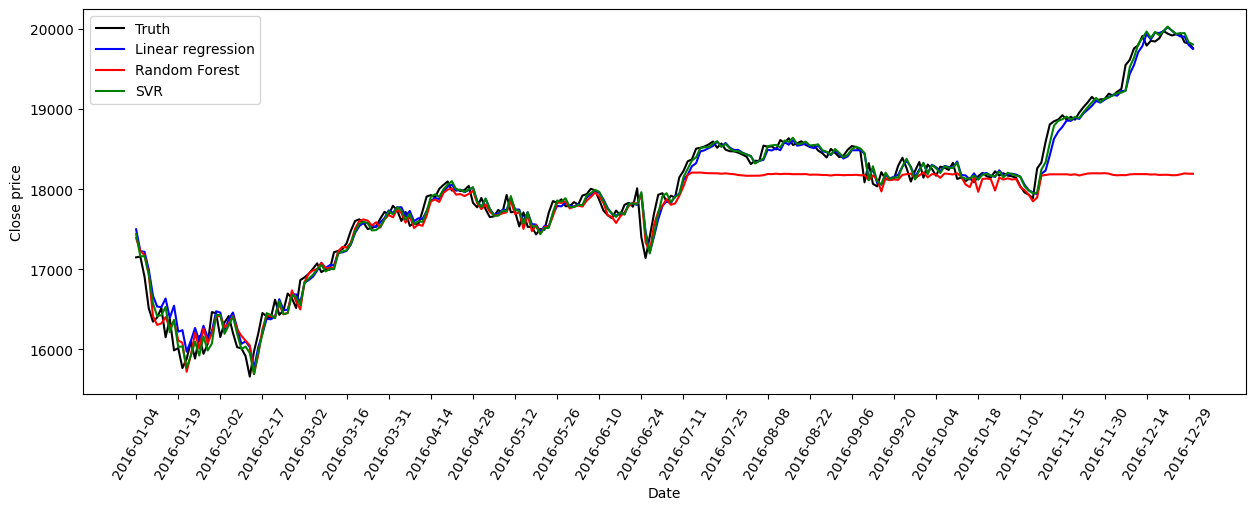

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_data.index, Y_test, 'k')
ax.plot(test_data.index, predictions_lr,'b')
ax.plot(test_data.index, predictions_rfr, 'r')
ax.plot(test_data.index, predictions_svr, 'g')
plt.xticks(range(0, 252, 10), rotation=60)
ax.set_xlabel('Date')
ax.set_ylabel('Close price')
ax.legend(['Truth', 'Linear regression', 'Random Forest', 'SVR'])
plt.show()